In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import importlib
import tweepy
import datetime
import re
import pickle
import matplotlib.pyplot as plt
from tweepy import OAuthHandler
import funcs as fs
import requests

### API params from file

In [3]:
ap = fs.set_api('tw_auth.csv')

### Dowloading tweets
No particular subject.

In [ ]:
all_t = fs.load_tweets(ap, ' ', 10000)

### Adding location
Not very effective :/

To be changed.

In [ ]:
for i in geo_df[geo_df.state==''].index:
    geo_df.state.loc[i] = fs.get_state(geo_df.location.loc[i])

### Geo data
Downloaded from [here](http://www.gugik.gov.pl/pzgik/dane-bez-oplat/dane-z-panstwowego-rejestru-granic-i-powierzchni-jednostek-podzialow-terytorialnych-kraju-prg).

Problems with coding may appear :/


In [55]:
pl_woj = gpd.read_file('woj.shp')

In [56]:
pl_woj = pl_woj[['jpt_nazwa_', 'geometry']].rename(columns={'jpt_nazwa_' : 'state'})

In [57]:
pl_woj

,state,geometry
0,opolskie,"POLYGON ((351531.3570542663 289023.6339908298,..."
1,świętokrzyskie,"POLYGON ((549668.108223389 320839.8468403742, ..."
2,kujawsko-pomorskie,"POLYGON ((383436.88102724 613642.8506025421, 3..."
3,mazowieckie,"POLYGON ((517613.878040235 508554.134765977, 5..."
4,śląskie,(POLYGON ((555951.3387101158 327976.5435710084...
5,warmińsko-mazurskie,"POLYGON ((508453.7807559089 637510.0399788385,..."
6,zachodniopomorskie,"POLYGON ((171677.5552177691 563602.5222216407,..."
7,dolnośląskie,"POLYGON ((205901.1020087924 343181.9550380595,..."
8,wielkopolskie,"POLYGON ((281964.3368720217 535152.7505267244,..."
9,łódzkie,"POLYGON ((435569.1798715355 387437.0388484262,..."


### Importing data from file.
Tweets with previously downloaded location and state data.

In [11]:
with open('geo.pickle', 'rb') as f:
    geo = pickle.load(f)

Removing "Nones" from get_state function and locations from outside Poland

In [17]:
geo = geo.dropna()

In [15]:
geo = geo.loc[[i for i in geo.index if geo.state.loc[i] in list(pl_woj.state)]]

In [18]:
len(geo)

1862

Converting types.

In [19]:
geo.friends_cnt = pd.to_numeric(geo.friends_cnt)
geo.foll_cnt = pd.to_numeric(geo.foll_cnt)

In [22]:
geo.head(1)

,tw_text,location,user_id,user_name,fav_cnt,friends_cnt,foll_cnt,state
1,. Chyba się upiłam :),Lublin,488608743,Krysia,26257,254,186,lubelskie


### Analysis of users

Cleaning the data from multiples users.

In [23]:
geo=geo.iloc[:,1:9]

In [35]:
geo_agg = geo.groupby(['state', 'user_id'])['friends_cnt', 'foll_cnt'].agg(max)

In [36]:
geo_agg = geo_agg.groupby('state')['friends_cnt', 'foll_cnt'].agg(['mean', 'size'])

In [37]:
geo_agg

friends_cnt          foll_cnt     
                            mean size         mean size
state                                                  
dolnośląskie          471.250000   76   901.302632   76
kujawsko-pomorskie    488.480000   25   987.560000   25
lubelskie             590.457143   35   845.742857   35
lubuskie              658.133333   15   496.000000   15
mazowieckie           762.519856  277  4933.418773  277
małopolskie           670.573333   75  1326.826667   75
opolskie             1126.157895   19   994.105263   19
podkarpackie          946.000000   27   984.518519   27
podlaskie             696.970588   34  1792.794118   34
pomorskie             599.274194   62  1165.467742   62
warmińsko-mazurskie   815.933333   15   753.066667   15
wielkopolskie         669.307692   78   847.961538   78
zachodniopomorskie    745.690476   42  1259.809524   42
łódzkie               702.764706   51   662.529412   51
śląskie               525.700855  117   580.111111  117
świętokrzyskie        904.125000   16  1712.375000   16

### Merging with geo data

In [39]:
geo_agg = geo_agg.reset_index()
plot_data = pd.merge(pl_woj, geo_agg, on='state')

C:\Users\Mag\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Mag\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.right = self.right.drop(right_drop, axis=1)


In [43]:
plot_data

,state,geometry,"(friends_cnt, mean)","(friends_cnt, size)","(foll_cnt, mean)","(foll_cnt, size)"
0,opolskie,"POLYGON ((351531.3570542663 289023.6339908298,...",1126.157895,19,994.105263,19
1,świętokrzyskie,"POLYGON ((549668.108223389 320839.8468403742, ...",904.125000,16,1712.375000,16
2,kujawsko-pomorskie,"POLYGON ((383436.88102724 613642.8506025421, 3...",488.480000,25,987.560000,25
3,mazowieckie,"POLYGON ((517613.878040235 508554.134765977, 5...",762.519856,277,4933.418773,277
4,śląskie,(POLYGON ((555951.3387101158 327976.5435710084...,525.700855,117,580.111111,117
5,warmińsko-mazurskie,"POLYGON ((508453.7807559089 637510.0399788385,...",815.933333,15,753.066667,15
6,zachodniopomorskie,"POLYGON ((171677.5552177691 563602.5222216407,...",745.690476,42,1259.809524,42
7,dolnośląskie,"POLYGON ((205901.1020087924 343181.9550380595,...",471.250000,76,901.302632,76
8,wielkopolskie,"POLYGON ((281964.3368720217 535152.7505267244,...",669.307692,78,847.961538,78
9,łódzkie,"POLYGON ((435569.1798715355 387437.0388484262,...",702.764706,51,662.529412,51


### Plots

In [44]:
plot_data.columns = [ 'state', 'geometry','friends_avg', 'friends_size', 'foll_avg', 'foll_size']

In [45]:
plot_data.head(1)

,state,geometry,friends_avg,friends_size,foll_avg,foll_size
0,opolskie,"POLYGON ((351531.3570542663 289023.6339908298,...",1126.157895,19,994.105263,19


C:\Users\Mag\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


(137166.64563126868, 896406.6565342784, 101133.9541251598, 807108.9159854098)

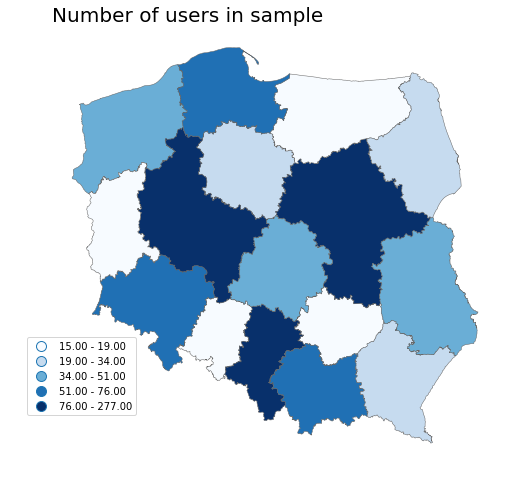

In [46]:
fig, ax = plt.subplots(1, figsize=(8, 8))
plot_data.plot(ax = ax, linewidth=0.5, edgecolor='0.4', column='friends_size', cmap='Blues', legend=True, scheme='quantiles')
ax.set_title('Number of users in sample', fontdict={'fontsize': 20}, loc='left')
ax.get_legend().set_bbox_to_anchor((.2, .3))
ax.axis('off')

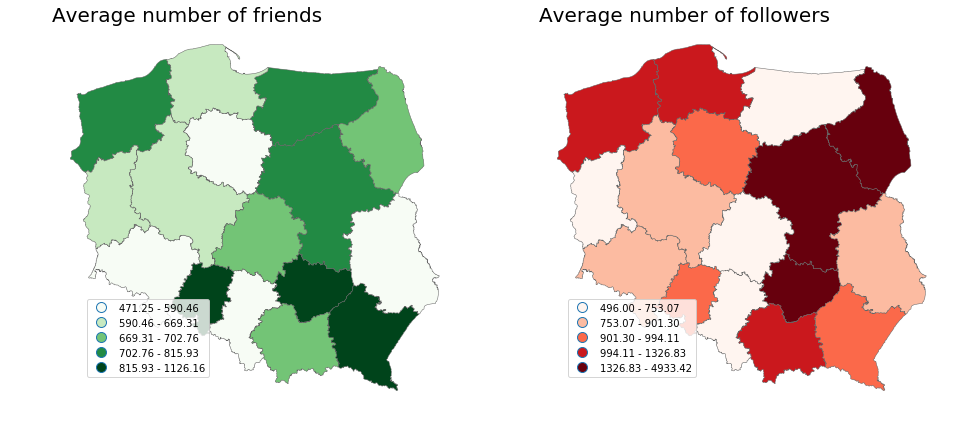

In [51]:
fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(121)
plot_data.plot(ax=ax1, linewidth=0.5, edgecolor='0.4', column='friends_avg', cmap='Greens', legend=True, scheme='quantiles')
ax1.set_title('Average number of friends', fontdict={'fontsize': 20}, loc='left')
ax1.get_legend().set_bbox_to_anchor((.4, .3))
ax1.axis('off')

ax2 = fig.add_subplot(122)
plot_data.plot(ax = ax2, linewidth=0.5, edgecolor='0.4', column='foll_avg', cmap='Reds', legend=True, scheme='quantiles')
ax2.set_title('Average number of followers', fontdict={'fontsize': 20}, loc='left')
ax2.get_legend().set_bbox_to_anchor((.4, .3))
ax2.axis('off')

plt.savefig('fig2.png')
plt.show()